In [1]:
import os
print(os.getcwd())

/data/idea2/YJ/git/SubpixelRendering/network/gridSearch


In [2]:
if(os.getcwd() == "C:\\Users\\편윤장\\IDEA"):
    os.chdir('./subpixel rendering/network/')
else:
    os.chdir('../..')
#     os.chdir('..')
cwd = os.getcwd()
print(cwd)

/data/idea2/YJ/git/SubpixelRendering


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
from IPython.display import clear_output
import numpy as np
import torch
from collections import deque
import sys
import os
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline
from torch.nn import functional
from torchsummaryX import summary
import torchvision
from torchvision import transforms as T
from skimage.io import imread

plt.rcParams["figure.figsize"] = (18, 16)

/home/idea/python3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from network.utilsH2 import dataset_gen, psnr, ssim
from network.myUtils import Vimg_Stripe, Vimg_Pentile, dataGen

In [6]:
ver = 'gridsearch/K3C256L32_separateWeight/'

In [7]:
gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    device = 'cuda:' + str(gpu_ids[-1])  # 여기서 gpu 번호 고르기
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

[0]
['NVIDIA GeForce RTX 3090']
cuda


In [8]:
# device_ids = ["cuda:0", "cuda:1", "cuda:2", "cuda:3"]
# device_ids = ["cuda:2", "cuda:1", "cuda:0"]
# device_ids = ["cuda:1", "cuda:0"]
device_ids = ["cuda:0"]

In [9]:
IF_g = torch.tensor([[0.25, 0.50, 0.25],
                    [0.50, 1.0, 0.50],
                    [0.25, 0.50, 0.25]])
IF_b = torch.tensor([[0, 0, 0, 0.06, 0, 0, 0],
                    [0, 0, 0.19, 0.25, 0.19, 0, 0],
                    [0, 0.19, 0.50, 0.56, 0.50, 0.19, 0],
                    [0.06, 0.25, 0.56, 1.0, 0.56, 0.25, 0.06],
                    [0, 0.19, 0.50, 0.56, 0.50, 0.19, 0],
                    [0, 0, 0.19, 0.25, 0.19, 0, 0],
                    [0, 0, 0, 0.06, 0, 0, 0]])

In [1]:
class rgb2pentile(torch.nn.Module):
    def __init__(self):
        super().__init__()
            
        kernel_size=(3,3)
        padding=1
        channels = 256
        relu_inplace = True
        
        self.layers_f = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=channels, kernel_size=kernel_size, padding=padding, padding_mode='replicate'),
            torch.nn.ReLU(inplace=relu_inplace),
            
            torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=padding, padding_mode='replicate'),
            torch.nn.ReLU(inplace=relu_inplace),
            
            torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=padding, padding_mode='replicate'),
            torch.nn.ReLU(inplace=relu_inplace)
        )
        self.layers_b = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=padding, padding_mode='replicate'),
            torch.nn.ReLU(inplace=relu_inplace),
            
            torch.nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=kernel_size, padding=padding, padding_mode='replicate')
        )
        
    def forward(self, x, pooling_size=(2,2)):
        x = self.layers_f(x)
        x = torch.nn.MaxPool2d(kernel_size=pooling_size)(x)
        x = self.layers_b(x)

        return x

NameError: name 'torch' is not defined

In [11]:
lr_init = 1e-4
step_size = 3
gamma = 0.7

In [12]:
parallel = False

In [13]:
pentileR = rgb2pentile().to(device=device)
pentileG = rgb2pentile().to(device=device)
pentileB = rgb2pentile().to(device=device)

In [14]:
if(parallel):
    pentileR = torch.nn.DataParallel(pentileR, device_ids=device_ids).to(device=device)
    pentileG = torch.nn.DataParallel(pentileG, device_ids=device_ids).to(device=device)
    pentileB = torch.nn.DataParallel(pentileB, device_ids=device_ids).to(device=device)

In [15]:
# pentileR = pentileR.module.to(device=device)
# pentileG = pentileG.module.to(device=device)
# pentileB = pentileB.module.to(device=device)

In [16]:
optR = torch.optim.Adam(params=pentileR.parameters(), lr=lr_init)
optG = torch.optim.Adam(params=pentileG.parameters(), lr=lr_init)
optB = torch.optim.Adam(params=pentileB.parameters(), lr=lr_init)
schedR = torch.optim.lr_scheduler.StepLR(optimizer=optR, step_size=step_size, gamma= gamma)
schedG = torch.optim.lr_scheduler.StepLR(optimizer=optG, step_size=step_size, gamma= gamma)
schedB = torch.optim.lr_scheduler.StepLR(optimizer=optB, step_size=step_size, gamma= gamma)
creterion = torch.nn.MSELoss()

In [17]:
# if(parallel):
#     summary(pentileG.module, torch.zeros(16,2,256,256,device=device))
# else:
#     summary(pentileG, torch.zeros(16,2,256,256,device=device))

In [18]:
if(parallel):
    summary(pentileR.module, torch.zeros(16,2,256,256,device=device))
else:
    summary(pentileR, torch.zeros(16,2,256,256,device=device))

                         Kernel Shape         Output Shape   Params  \
Layer                                                                 
0_layers_f.Conv2d_0    [2, 256, 3, 3]  [16, 256, 256, 256]   4.864k   
1_layers_f.ReLU_1                   -  [16, 256, 256, 256]        -   
2_layers_f.Conv2d_2  [256, 256, 3, 3]  [16, 256, 256, 256]  590.08k   
3_layers_f.ReLU_3                   -  [16, 256, 256, 256]        -   
4_layers_f.Conv2d_4  [256, 256, 3, 3]  [16, 256, 256, 256]  590.08k   
5_layers_f.ReLU_5                   -  [16, 256, 256, 256]        -   
6_layers_b.Conv2d_0  [256, 256, 3, 3]  [16, 256, 128, 128]  590.08k   
7_layers_b.ReLU_1                   -  [16, 256, 128, 128]        -   
8_layers_b.Conv2d_2    [256, 1, 3, 3]    [16, 1, 128, 128]   2.305k   

                         Mult-Adds  
Layer                               
0_layers_f.Conv2d_0    301.989888M  
1_layers_f.ReLU_1                -  
2_layers_f.Conv2d_2  38.654705664G  
3_layers_f.ReLU_3                

/home/idea/python3.9/lib/python3.9/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [19]:
path_img = 'SPA/dataset/original image/'
names_img = os.listdir(path_img)
# print(names_img)

In [20]:
names_img = sorted(names_img)
# print(names_img)

In [21]:
if(os.getcwd() == "C:\\Users\\편윤장\\IDEA\\subpixel rendering\\network"):
    PATH_train = '../network/scratch/dataset/train/HR/'
    PATH_val = '../network/scratch/dataset/train/ValHR/'
else:
    PATH_train = '../../FovSR/Dataset/train/HR/'
    PATH_val = '../../FovSR/Dataset/train/ValHR/'

In [22]:
path_checkpoint = 'network/checkpoint/' + ver
if not os.path.exists(path_checkpoint):
    os.makedirs(path_checkpoint)

In [23]:
path_result = 'network/result/' + ver
if not os.path.exists(path_result):
    os.makedirs(path_result)

In [24]:
fileList = os.listdir(PATH_train)
names = [file for file in fileList if file.endswith(".png")]
names = sorted(names)

In [25]:
fileList_val = os.listdir(PATH_val)
names_val = [file for file in os.listdir(PATH_val) if file.endswith(".png")]
names_val = sorted(names_val)

In [26]:
# print(dataGen(os.path.join(PATH_train, names[0])).shape)

In [27]:
epoch = 0
step = 0

In [28]:
steps = 9.3e4
crop_size = 192
batch_size = 4

In [29]:
count = []
count_val = [0]
lossR_plot = []
lossG_plot = []
lossB_plot = []
lossR_val_plot = [0]
lossG_val_plot = [0]
lossB_val_plot = [0]
psnr_plot = []
psnr_val_plot = [0]

filter_rb = IF_b.unsqueeze(0).unsqueeze(0).to(device)
filter_g = IF_g.unsqueeze(0).unsqueeze(0).to(device)

Mon Jul  3 01:45:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
| 75%   66C    P2   328W / 350W |  15355MiB / 24268MiB |     88%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:5E:00.0 Off |                  N/A |
| 70%   

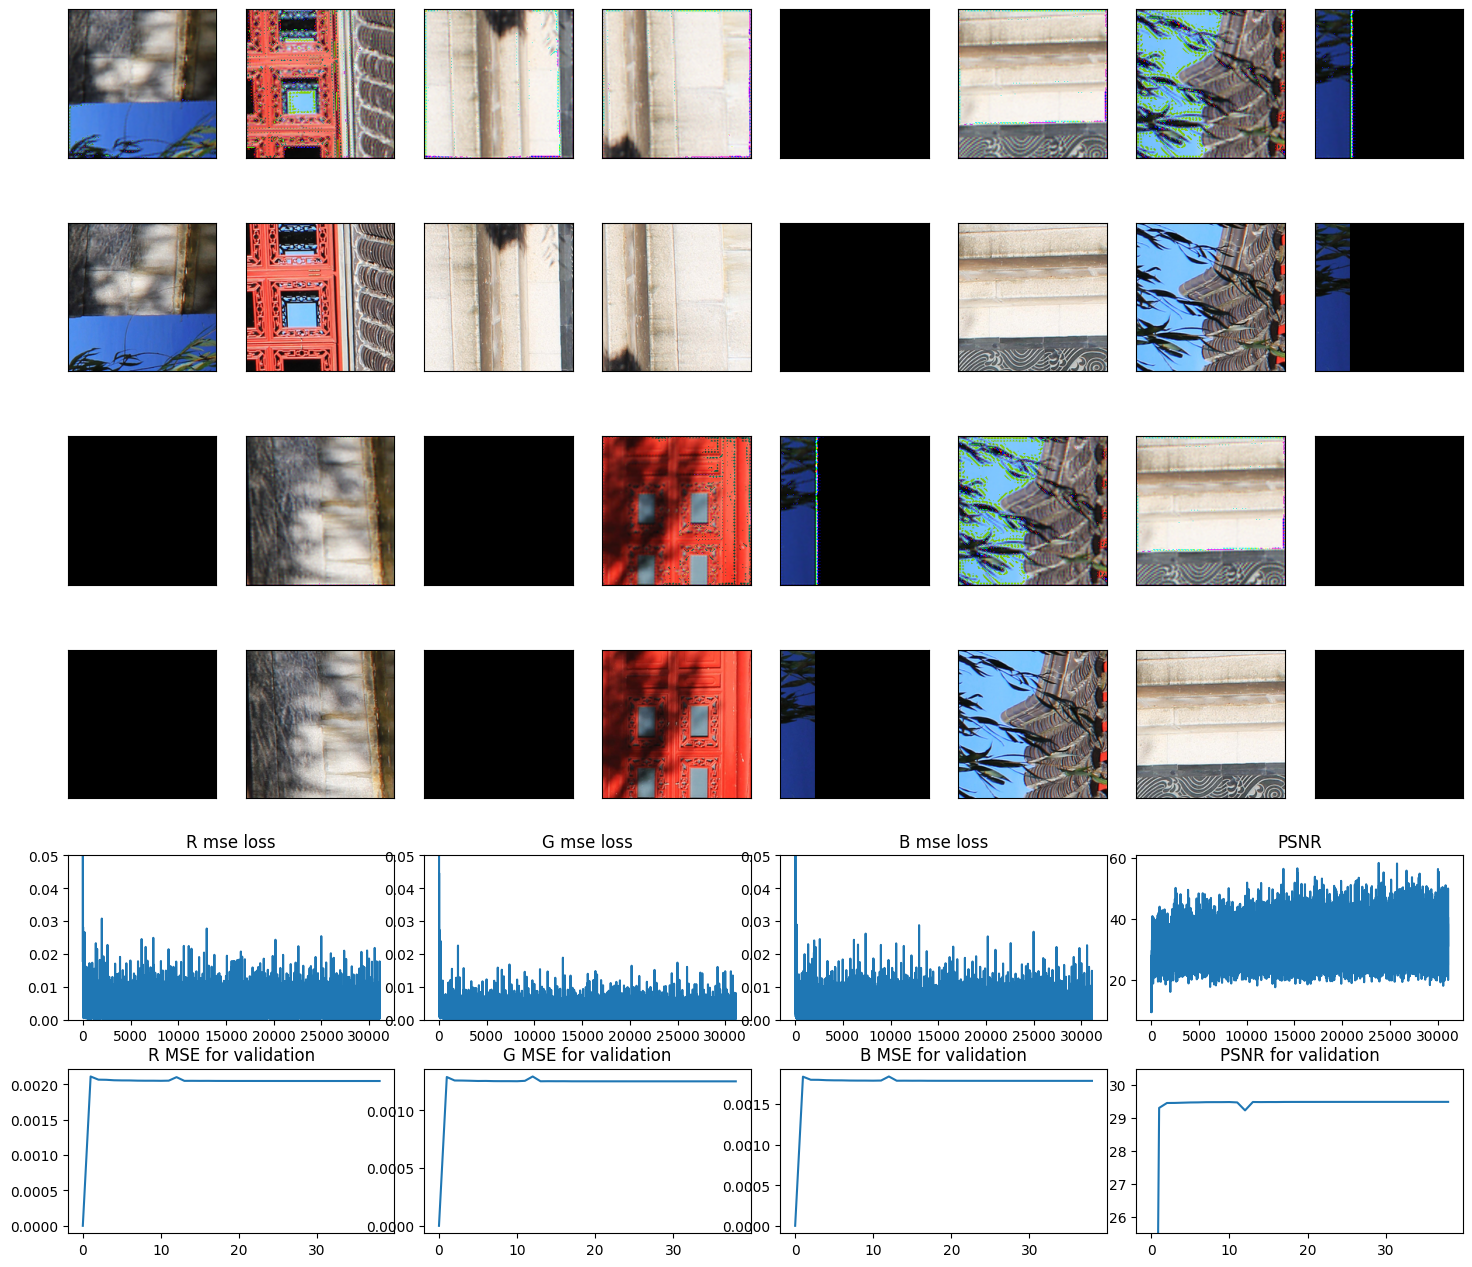

Checkpoint saved.


In [30]:
# while True:
while step < steps:
    for name in names:
        optR.zero_grad()
        optG.zero_grad()
        optB.zero_grad()
        
        target = dataGen(os.path.join(PATH_train, name), crop_size=crop_size, batch_size=batch_size, device=device)

        mask_r = torch.zeros_like(target[:,0,:,:].unsqueeze(1))
        mask_r[:,:,1::4, 1::4] = 1.
        mask_r[:,:,3::4, 3::4] = 1.

        mask_g = torch.zeros_like(target[:,0,:,:].unsqueeze(1))
        mask_g[:,:,::2,::2] = 1.

        mask_b = torch.zeros_like(target[:,0,:,:].unsqueeze(1))
        mask_b[:,:,1::4, 3::4] = 1.
        mask_b[:,:,3::4, 1::4] = 1.
        
        pR = pentileR(torch.cat((target[:,0,:,:].unsqueeze(1),mask_r),dim=1), pooling_size=(2,4))
        pG = pentileG(torch.cat((target[:,1,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2))
        pB = pentileB(torch.cat((target[:,2,:,:].unsqueeze(1),mask_b),dim=1), pooling_size=(2,4))

        vimg = Vimg_Pentile(pR, pG, pB, filter_rb, filter_g)
        
        lossG = creterion(vimg[:,1,:,:].unsqueeze(1), target[:,1,:,:].unsqueeze(1))
        lossR = creterion(vimg[:,0,:,:].unsqueeze(1), target[:,0,:,:].unsqueeze(1))
        lossB = creterion(vimg[:,2,:,:].unsqueeze(1), target[:,2,:,:].unsqueeze(1))
        
        count.append(step)
        lossG_plot.append(lossG.detach().cpu())
        lossR_plot.append(lossR.detach().cpu())
        lossB_plot.append(lossB.detach().cpu())

        psnr_avg = 0
        for i in range(len(target)):
            psnr_ = psnr(vimg[i].detach().cpu()*255, target[i].detach().cpu()*255)
            psnr_avg += psnr_
        psnr_avg = psnr_avg / len(target)
        psnr_plot.append(psnr_avg)

        lossG.backward(retain_graph=True)
        lossR.backward(retain_graph=True)
        lossB.backward(retain_graph=True)
        optR.step()
        optG.step()
        optB.step()

        del pR, pG, pB

        if step % 100 == 0:
            clear_output()
            !nvidia-smi

            curlr = optR.state_dict()['param_groups'][0]['lr']
            initlr = optR.state_dict()['param_groups'][0]['initial_lr']
            print(f'epoch {epoch}, iterate {step}\
                \ncurrent_lr {curlr}, initial_lr {initlr}\
                \nlossR {lossR} lossG {lossG} lossB {lossB} avg_psnr {psnr_avg}\
                \nval_lossR {lossR_val_plot[-1]} val_lossG {lossG_val_plot[-1]} val_lossB {lossB_val_plot[-1]} val_psnr {psnr_val_plot[-1]}')
            gridshape = (6, 8)
            
            for i in range(min(8, batch_size)):
                loc = (0, i)
                ax = plt.subplot2grid(gridshape, loc)
                plt.imshow(np.clip(T.ToPILImage()(vimg[i]),0,255))
#                 ax.axis(False)
                ax.set_xticks([])
                ax.set_yticks([])

            for i in range(min(8, batch_size)):
                loc = (1, i)
                ax = plt.subplot2grid(gridshape, loc)
                plt.imshow(np.array(T.ToPILImage()(target[i])))
#                 ax.axis(False)
                ax.set_xticks([])
                ax.set_yticks([])
                
            for i in range(min(8, batch_size)):
                loc = (2, i)
                ax = plt.subplot2grid(gridshape, loc)
                plt.imshow(np.clip(T.ToPILImage()(vimg[-(i+1)]),0,255))
#                 ax.axis(False)
                ax.set_xticks([])
                ax.set_yticks([])

            for i in range(min(8, batch_size)):
                loc = (3, i)
                ax = plt.subplot2grid(gridshape, loc)
                plt.imshow(np.array(T.ToPILImage()(target[-(i+1)][:3,:,:])))
#                 ax.axis(False)
                ax.set_xticks([])
                ax.set_yticks([])
            
            loc = (4, 0)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count,lossR_plot)
            if(epoch>10):
                plt.ylim(0, 0.05)
            plt.title("R mse loss")
            
            loc = (4, 2)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count,lossG_plot)
            if(epoch>10):
                plt.ylim(0, 0.05)
            plt.title("G mse loss")
            
            loc = (4, 4)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count,lossB_plot)
            if(epoch>10):
                plt.ylim(0, 0.05)
            plt.title("B mse loss")
            
            loc = (4, 6)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count,psnr_plot)
            plt.title("PSNR")
            
            loc = (5, 0)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count_val,lossR_val_plot)
            plt.title("R MSE for validation")
            plt.subplots_adjust(hspace=0.3)
            
            loc = (5, 2)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count_val,lossG_val_plot)
            plt.title("G MSE for validation")
            
            loc = (5, 4)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count_val,lossB_val_plot)
            plt.title("B MSE for validation")
            
            loc = (5, 6)
            plt.subplot2grid(gridshape, loc, colspan=2)
            plt.plot(count_val,psnr_val_plot)
            plt.ylim(np.max(psnr_val_plot)-4,np.max(psnr_val_plot)+1)
            plt.title("PSNR for validation")
            
            # plt.tight_layout()
            plt.subplots_adjust(hspace=0.3)
            plt.show()
        
        step += 1
    schedR.step()
    schedG.step()
    schedB.step()
    epoch += 1
    
    #validation
    with torch.no_grad():
        psnr_val = []
        lossR_val = []
        lossG_val = []
        lossB_val = []
        count_val.append(epoch)
        pentileR.eval()
        pentileG.eval()
        pentileB.eval()
        
        for name in names_val:
            img = imread(os.path.join(PATH_val, name))
            timg = T.ToTensor()(img.copy())
            timg = timg.unsqueeze(0).to(device=device)
            
            mask_r = torch.zeros_like(timg[:,0,:,:].unsqueeze(1))
            mask_r[:,:,1::4, 1::4] = 1.
            mask_r[:,:,3::4, 3::4] = 1.

            mask_g = torch.zeros_like(timg[:,0,:,:].unsqueeze(1))
            mask_g[:,:,::2,::2] = 1.

            mask_b = torch.zeros_like(timg[:,0,:,:].unsqueeze(1))
            mask_b[:,:,1::4, 3::4] = 1.
            mask_b[:,:,3::4, 1::4] = 1.
            
            try:
                if(parallel):
#                     pR = pentileR.module.to(device)(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1)).to(device='cpu')
#                     pG = pentileG.module.to(device)(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1)).to(device='cpu')
#                     pB = pentileR.module.to(device)(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1)).to(device='cpu')
                    pR = pentileR.module.to(device)(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1), pooling_size=(2,4)).to(device='cpu')
                    pG = pentileG.module.to(device)(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                    pB = pentileB.module.to(device)(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1), pooling_size=(2,4)).to(device='cpu')
                else:
#                     pR = pentileR(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1)).to(device='cpu')
#                     pG = pentileG(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1)).to(device='cpu')
#                     pB = pentileR(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1)).to(device='cpu')
                    pR = pentileR(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1), pooling_size=(2,4)).to(device='cpu')
                    pG = pentileG(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                    pB = pentileB(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1), pooling_size=(2,4)).to(device='cpu')
            except:
                if(parallel):
#                     pR = pentileR.module.to('cpu')(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1).cpu())
#                     pG = pentileR.module.to('cpu')(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1).cpu())
#                     pB = pentileR.module.to('cpu')(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1).cpu())
                    pR = pentileR.module.to('cpu')(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1).cpu(), pooling_size=(2,4))
                    pG = pentileG.module.to('cpu')(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1).cpu(), pooling_size=(2,2))
                    pB = pentileB.module.to('cpu')(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1).cpu(), pooling_size=(2,4))
                    
                    pentileR.module.to(device)
                    pentileG.module.to(device)
                    pentileB.module.to(device)
                else:
#                     pR = pentileR.to('cpu')(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1).to('cpu'))
#                     pG = pentileR.to('cpu')(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1).to('cpu'))
#                     pB = pentileR.to('cpu')(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1).to('cpu'))
                    pR = pentileR.to('cpu')(torch.cat((timg[:,0,:,:].unsqueeze(1),mask_r),dim=1).to('cpu'), pooling_size=(2,4))
                    pG = pentileG.to('cpu')(torch.cat((timg[:,1,:,:].unsqueeze(1),mask_g),dim=1).to('cpu'), pooling_size=(2,2))
                    pB = pentileB.to('cpu')(torch.cat((timg[:,2,:,:].unsqueeze(1),mask_b),dim=1).to('cpu'), pooling_size=(2,4))

                    pentileR.to(device)
                    pentileG.to(device)
                    pentileB.to(device)

            tvimg = Vimg_Pentile(pR, pG, pB, filter_rb.to(device='cpu'), filter_g.to(device='cpu'))
            del pR, pG, pB
            torch.cuda.empty_cache()

            vimg = tvimg[0].detach().cpu().permute((1,2,0))*255
    
            if(img.shape[0]%2==0):
                if(img.shape[1]%2==0):
                    psnr_ = psnr(vimg, img[:,:,:])
                    lossR = creterion(tvimg[:,0,:,:].unsqueeze(1), timg[:,0,:,:].unsqueeze(1).cpu())
                    lossG = creterion(tvimg[:,1,:,:].unsqueeze(1), timg[:,1,:,:].unsqueeze(1).cpu())
                    lossB = creterion(tvimg[:,2,:,:].unsqueeze(1), timg[:,2,:,:].unsqueeze(1).cpu())
                else:
                    psnr_ = psnr(vimg, img[:,:-1,:])
                    lossR = creterion(tvimg[:,0,:,:].unsqueeze(1), timg[:,0,:,:-1].unsqueeze(1).cpu())
                    lossG = creterion(tvimg[:,1,:,:].unsqueeze(1), timg[:,1,:,:-1].unsqueeze(1).cpu())
                    lossB = creterion(tvimg[:,2,:,:].unsqueeze(1), timg[:,2,:,:-1].unsqueeze(1).cpu())
            else:
                if(img.shape[1]%2==0):
                    psnr_ = psnr(vimg, img[:-1,:,:])
                    lossR = creterion(tvimg[:,0,:,:].unsqueeze(1), timg[:,0,:-1,:].unsqueeze(1).cpu())
                    lossG = creterion(tvimg[:,1,:,:].unsqueeze(1), timg[:,1,:-1,:].unsqueeze(1).cpu())
                    lossB = creterion(tvimg[:,2,:,:].unsqueeze(1), timg[:,2,:-1,:].unsqueeze(1).cpu())
                else:
                    psnr_ = psnr(vimg, img[:-1,:-1,:])
                    lossR = creterion(tvimg[:,0,:,:].unsqueeze(1), timg[:,0,:-1,:-1].unsqueeze(1).cpu())
                    lossG = creterion(tvimg[:,1,:,:].unsqueeze(1), timg[:,1,:-1,:-1].unsqueeze(1).cpu())
                    lossB = creterion(tvimg[:,2,:,:].unsqueeze(1), timg[:,2,:-1,:-1].unsqueeze(1).cpu())
            lossR_val.append(lossR)
            lossG_val.append(lossG)
            lossB_val.append(lossB)
            psnr_val.append(psnr_)
        lossR_val_plot.append(np.mean(lossR_val))
        lossG_val_plot.append(np.mean(lossG_val))
        lossB_val_plot.append(np.mean(lossB_val))
        psnr_val_plot.append(np.mean(psnr_val))
        
        pentileR.train()
        pentileG.train()
        pentileB.train()
        
    try:
        if(psnr_val_plot[-1] > np.max(psnr_val_plot[:-1])):
            # model save
            torch.save({'epoch': epoch,
                        'modelR_state_dict': pentileR.state_dict(),
                        'modelG_state_dict': pentileG.state_dict(),
                        'modelB_state_dict': pentileB.state_dict(),
                        'optimizerR_state_dict': optR.state_dict(),
                        'optimizerG_state_dict': optG.state_dict(),
                        'optimizerB_state_dict': optB.state_dict(),
                        }, path_checkpoint+'train_checkpoint'+str(epoch%10)+'_model.pt')
            torch.save({'epoch': epoch,
                        'count': count,
                        'count_val': count_val,
                        'lossR_plot': lossR_plot,
                        'lossG_plot': lossG_plot,
                        'lossB_plot': lossB_plot,
                        'lossR_val_plot': lossR_val_plot,
                        'lossG_val_plot': lossG_val_plot,
                        'lossB_val_plot': lossB_val_plot,
                        'psnr_plot': psnr_plot,
                        'psnr_val_plot': psnr_val_plot
                        }, path_checkpoint+'train_checkpoint'+str(epoch%10)+'_data.pt')
            print("Checkpoint saved.")
        else:
            print("Saving checkpoint skipped.")
    except:
        print("Saving checkpoint failed.")

Text(0.5, 1.0, 'B mse loss')

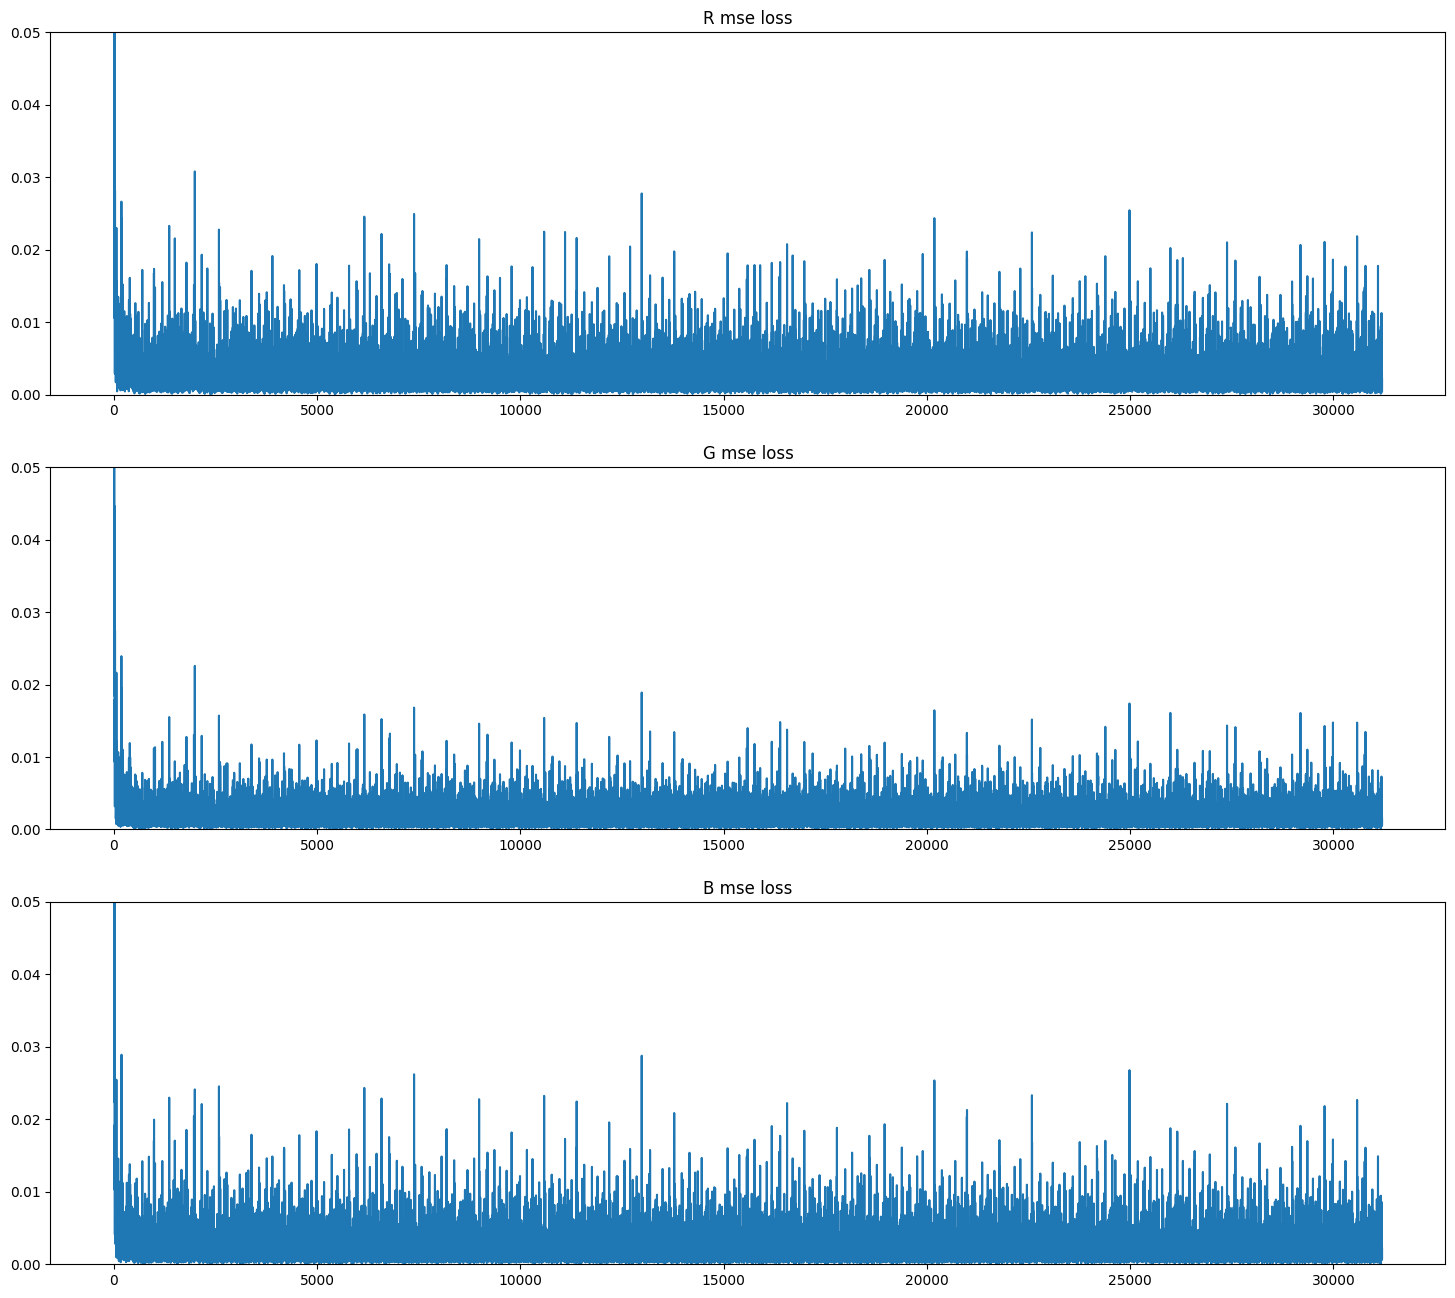

In [31]:
gridshape = (3,1)
y_bot = 0
y_top = 0.05

loc = (0, 0)
plt.subplot2grid(gridshape, loc)
plt.plot(count,lossR_plot)
plt.ylim(y_bot, y_top)
plt.title("R mse loss")

loc = (1, 0)
plt.subplot2grid(gridshape, loc)
plt.plot(count,lossG_plot)
plt.ylim(y_bot, y_top)
plt.title("G mse loss")

loc = (2, 0)
plt.subplot2grid(gridshape, loc)
plt.plot(count,lossB_plot)
plt.ylim(y_bot, y_top)
plt.title("B mse loss")

In [32]:
load = False
checkpointNum = '9'

In [33]:
if(load):
    checkpoint_model = torch.load(path_checkpoint+'train_checkpoint' + checkpointNum +'_model.pt',
                                 map_location=device)
    # checkpoint_model = torch.load('checkpoint/channelwise/train_checkpoint5_model.pt')

    epoch = checkpoint_model['epoch']
    pentileR.load_state_dict(checkpoint_model['modelR_state_dict'])
    pentileG.load_state_dict(checkpoint_model['modelG_state_dict'])
    pentileB.load_state_dict(checkpoint_model['modelB_state_dict'])
    optR.load_state_dict(checkpoint_model['optimizerR_state_dict'])
    optG.load_state_dict(checkpoint_model['optimizerG_state_dict'])
    optB.load_state_dict(checkpoint_model['optimizerB_state_dict'])

In [34]:
if(load):
    checkpoint_data = torch.load(path_checkpoint+'train_checkpoint' + checkpointNum +'_data.pt')#,
#                                  map_location=device)
    # checkpoint_model = torch.load('checkpoint/channelwise/train_checkpoint5_model.pt')

    epoch = checkpoint_data['epoch']
    count = checkpoint_data['count']
    count_val = checkpoint_data['count_val']
    lossR_plot = checkpoint_data['lossR_plot']
    lossG_plot = checkpoint_data['lossG_plot']
    lossB_plot = checkpoint_data['lossB_plot']
    lossR_val_plot = checkpoint_data['lossR_val_plot']
    lossG_val_plot = checkpoint_data['lossG_val_plot']
    lossB_val_plot = checkpoint_data['lossB_val_plot']
    psnr_plot = checkpoint_data['psnr_plot']
    psnr_val_plot = checkpoint_data['psnr_val_plot']

In [35]:
Graphs = True

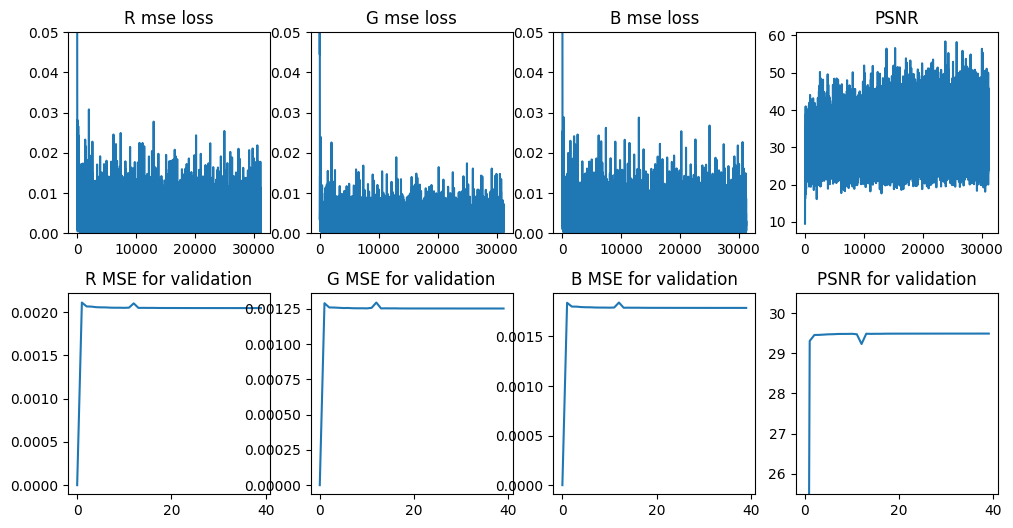

In [36]:
if(Graphs):
    gridshape = (2,4)
    plt.figure(figsize=(12,6))
    
    loc = (0, 0)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count,lossR_plot)
    if(epoch>10):
        plt.ylim(0, 0.05)
    plt.title("R mse loss")

    loc = (0, 1)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count,lossG_plot)
    if(epoch>10):
        plt.ylim(0, 0.05)
    plt.title("G mse loss")

    loc = (0, 2)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count,lossB_plot)
    if(epoch>10):
        plt.ylim(0, 0.05)
    plt.title("B mse loss")

    loc = (0, 3)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count,psnr_plot)
    plt.title("PSNR")

    loc = (1, 0)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count_val,lossR_val_plot)
    plt.title("R MSE for validation")
    plt.subplots_adjust(hspace=0.3)

    loc = (1, 1)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count_val,lossG_val_plot)
    plt.title("G MSE for validation")

    loc = (1, 2)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count_val,lossB_val_plot)
    plt.title("B MSE for validation")

    loc = (1, 3)
    plt.subplot2grid(gridshape, loc, colspan=1)
    plt.plot(count_val,psnr_val_plot)
    plt.ylim(np.max(psnr_val_plot)-4,np.max(psnr_val_plot)+1)
    plt.title("PSNR for validation")

    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [37]:
psnr_comp = []
ssim_comp = []
time_ = []

In [38]:
pentileR.eval()
pentileG.eval()
pentileB.eval()

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for name in names_img:
    with torch.no_grad():
        testimg = imread(os.path.join(path_img, name))
        print(name)
        ttestimg = T.ToTensor()(testimg.copy())
        ttestimg = ttestimg.unsqueeze(0).to(device=device)

        mask_r = torch.zeros_like(ttestimg[:,0,:,:].unsqueeze(1))
        mask_r[:,:,1::4, 1::4] = 1.
        mask_r[:,:,3::4, 3::4] = 1.

        mask_g = torch.zeros_like(ttestimg[:,0,:,:].unsqueeze(1))
        mask_g[:,:,::2,::2] = 1.

        mask_b = torch.zeros_like(ttestimg[:,0,:,:].unsqueeze(1))
        mask_b[:,:,1::4, 3::4] = 1.
        mask_b[:,:,3::4, 1::4] = 1.
        
        start.record()
        dev = ''
        
        try:
            if(parallel):
#                 tR = pentileR.module.to(device)(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1)).to(device='cpu')
#                 tG = pentileG.module.to(device)(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1)).to(device='cpu')
#                 tB = pentileR.module.to(device)(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1)).to(device='cpu')
                tR = pentileR.module.to(device)(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1), pooling_size=(2,4)).to(device='cpu')
                tG = pentileG.module.to(device)(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                tB = pentileB.module.to(device)(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1), pooling_size=(2,4)).to(device='cpu')
            else:
#                 tR = pentileR(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1)).to(device='cpu')
#                 tG = pentileG(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1)).to(device='cpu')
#                 tB = pentileR(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1)).to(device='cpu')
                tR = pentileR(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1), pooling_size=(2,4)).to(device='cpu')
                tG = pentileG(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                tB = pentileB(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1), pooling_size=(2,4)).to(device='cpu')
#             print('cuda')
            dev = 'cuda'
        except:
            if(parallel):
#                 tR = pentileR.module.to('cpu')(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1).cpu())
#                 tG = pentileG.module.to('cpu')(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1).cpu())
#                 tB = pentileR.module.to('cpu')(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1).cpu())
                tR = pentileR.module.to('cpu')(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1).cpu(), pooling_size=(2,4))
                tG = pentileG.module.to('cpu')(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1).cpu(), pooling_size=(2,2))
                tB = pentileB.module.to('cpu')(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1).cpu(), pooling_size=(2,4))
            else:
                pentileR.to('cpu')
                pentileG.to('cpu')
                pentileB.to('cpu')

#                 tR = pentileR(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1).to('cpu'))
#                 tG = pentileG(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1).to('cpu'))
#                 tB = pentileR(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1).to('cpu'))
                tR = pentileR(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_r),dim=1).to('cpu'), pooling_size=(2,4))
                tG = pentileG(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1).to('cpu'), pooling_size=(2,2))
                tB = pentileB(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_b),dim=1).to('cpu'), pooling_size=(2,4))

                pentileR.to(device)
                pentileG.to(device)
                pentileB.to(device)
            dev = 'cpu'

        # calculate elapsed time
        end.record()
        torch.cuda.synchronize()
        time_e = start.elapsed_time(end)
        time_.append([time_e])
                
        name_ = name.split(sep='.')
        plt.imsave(path_result + name_[0] + '_pR.' + name_[1], np.array(T.ToPILImage()(torch.clip(tR,0.,1.).squeeze(0))),cmap='gray')
        plt.imsave(path_result + name_[0] + '_pG.' + name_[1], np.array(T.ToPILImage()(torch.clip(tG,0.,1.).squeeze(0))),cmap='gray')
        plt.imsave(path_result + name_[0] + '_pB.' + name_[1], np.array(T.ToPILImage()(torch.clip(tB,0.,1.).squeeze(0))),cmap='gray')
        
        tvimg = Vimg_Pentile(tR, tG, tB, filter_rb.to(device='cpu'), filter_g.to(device='cpu'))
        del tR, tG, tB
        torch.cuda.empty_cache()
        # print('2')
        
        vimg = tvimg[0].detach().cpu().permute((1,2,0))*255
        # print('3')
        
        # name_ = name.split(sep='.')
        plt.imsave(path_result + name, torch.clip(vimg,0.,255.).numpy().astype(np.uint8))
    
    if(testimg.shape[0]%2==0):
        if(testimg.shape[1]%2==0):
            psnr_ = psnr(vimg, testimg[:,:,:])
            ssim_ = ssim(vimg, testimg[:,:,:])
        else:
            psnr_ = psnr(vimg, testimg[:,:-1,:])
            ssim_ = ssim(vimg, testimg[:,:-1,:])
    else:
        if(testimg.shape[1]%2==0):
            psnr_ = psnr(vimg, testimg[:-1,:,:])
            ssim_ = ssim(vimg, testimg[:-1,:,:])
        else:
            psnr_ = psnr(vimg, testimg[:-1,:-1,:])
            ssim_ = ssim(vimg, testimg[:-1,:-1,:])
    # print('4')
    print(f'{name} - psnr: {psnr_}, ssim: {ssim_}, device: {dev}, elapsed time: {time_e:.4f}ms')

    psnr_comp.append([psnr_])#[name, psnr_])
    ssim_comp.append([ssim_])#[name, ssim_])

1-5.JPG
1-5.JPG - psnr: 35.70508816101315, ssim: 0.9908357073549764, device: cpu, elapsed time: 235304.7344ms
2-1.jpg
2-1.jpg - psnr: 27.388136844318034, ssim: 0.9504422799295729, device: cuda, elapsed time: 519.7751ms
2-10.JPG
2-10.JPG - psnr: 33.54758910638629, ssim: 0.9896140928166628, device: cpu, elapsed time: 235530.3750ms
2-12.JPG
2-12.JPG - psnr: 30.861517633123672, ssim: 0.9837406151489659, device: cpu, elapsed time: 238049.7031ms
2-20.JPG
2-20.JPG - psnr: 34.432874730683295, ssim: 0.991499874068064, device: cpu, elapsed time: 277404.0312ms
2-25.JPG
2-25.JPG - psnr: 32.99345041055278, ssim: 0.9886614691204675, device: cpu, elapsed time: 267115.1250ms
2-27.JPG
2-27.JPG - psnr: 36.96731129176315, ssim: 0.9941597026308777, device: cpu, elapsed time: 261600.6875ms
2-29.JPG
2-29.JPG - psnr: 33.23002680344631, ssim: 0.9888676041391585, device: cpu, elapsed time: 266917.1875ms
2-3.JPG
2-3.JPG - psnr: 34.64394621974065, ssim: 0.9902723672641798, device: cpu, elapsed time: 194958.9531m

In [39]:
avgpsnr = np.mean(psnr_comp)
avgssim = np.mean(ssim_comp)
print(f'Avg psnr: {avgpsnr}, Avg ssim: {avgpsnr}')

Avg psnr: 32.60267774302592, Avg ssim: 32.60267774302592


In [40]:
np.savetxt(path_result + 'psnr.csv', psnr_comp, fmt='%s', delimiter=',')
np.savetxt(path_result + 'ssim.csv', ssim_comp, fmt='%s', delimiter=',')

In [41]:
path_result_stripe = 'network/result/' + ver +'stripe/'
if not os.path.exists(path_result_stripe):
    os.makedirs(path_result_stripe)

In [42]:
psnr_stripe = []
ssim_stripe = []

In [43]:
pentileR.eval()
pentileG.eval()
pentileB.eval()

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for name in names_img:
    with torch.no_grad():
        testimg = imread(os.path.join(path_img, name))
#         print(name)
        ttestimg = T.ToTensor()(testimg.copy())
        ttestimg = ttestimg.unsqueeze(0).to(device=device)

        mask_g = torch.zeros_like(ttestimg[:,0,:,:].unsqueeze(1))
        mask_g[:,:,::2,::2] = 1.
        
        
        start.record()
        
        try:
            if(parallel):
                tR = pentileR.module.to(device)(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                tG = pentileG.module.to(device)(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                tB = pentileB.module.to(device)(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
            else:
                tR = pentileR(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                tG = pentileG(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
                tB = pentileB(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_g),dim=1), pooling_size=(2,2)).to(device='cpu')
            dev = 'cuda'
#             print('cuda')
        except:
            if(parallel):
                tR = pentileR.module.to('cpu')(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_g),dim=1).cpu(), pooling_size=(2,2))
                tG = pentileG.module.to('cpu')(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1).cpu(), pooling_size=(2,2))
                tB = pentileB.module.to('cpu')(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_g),dim=1).cpu(), pooling_size=(2,2))
            else:
                pentileR.to('cpu')
                pentileG.to('cpu')
                pentileB.to('cpu')

                tR = pentileR(torch.cat((ttestimg[:,0,:,:].unsqueeze(1),mask_g),dim=1).to('cpu'), pooling_size=(2,2))
                tG = pentileG(torch.cat((ttestimg[:,1,:,:].unsqueeze(1),mask_g),dim=1).to('cpu'), pooling_size=(2,2))
                tB = pentileB(torch.cat((ttestimg[:,2,:,:].unsqueeze(1),mask_g),dim=1).to('cpu'), pooling_size=(2,2))

                pentileR.to(device)
                pentileG.to(device)
                pentileB.to(device)
            dev = 'cpu'
                
        
        # calculate elapsed time
        end.record()
        torch.cuda.synchronize()
        time_e = start.elapsed_time(end)
        time_.append([time_e])
                
        name_ = name.split(sep='.')
        plt.imsave(path_result_stripe + name_[0] + '_R.' + name_[1],
                   np.array(T.ToPILImage()(torch.clip(tR,0.,1.).squeeze(0))),cmap='gray')
        plt.imsave(path_result_stripe + name_[0] + '_G.' + name_[1],
                   np.array(T.ToPILImage()(torch.clip(tG,0.,1.).squeeze(0))),cmap='gray')
        plt.imsave(path_result_stripe + name_[0] + '_B.' + name_[1],
                   np.array(T.ToPILImage()(torch.clip(tB,0.,1.).squeeze(0))),cmap='gray')
        
        tvimg = Vimg_Stripe(tR, tG, tB, filter_g.to(device='cpu'))
#         tvimg = functional.conv_transpose2d(torch.cat((tR, tG, tB),dim=1).cpu(), weight=filter_g.repeat(3,1,1,1).cpu(), stride=2, groups=3)
#       tvimg = Vimg_Pentile(tR, tG, tB, filter_rb.to(device='cpu'), filter_g.to(device='cpu'))
        del tR, tG, tB
        torch.cuda.empty_cache()
        # print('2')
#         print(testimg.shape,tvimg.shape)
        
        vimg = tvimg[0].detach().cpu().permute((1,2,0))*255
        # print('3')
        
        # name_ = name.split(sep='.')
        plt.imsave(path_result_stripe + name, torch.clip(vimg,0.,255.).numpy().astype(np.uint8))
    
    if(testimg.shape[0]%2==0):
        if(testimg.shape[1]%2==0):
            psnr_ = psnr(vimg, testimg[:,:,:])
            ssim_ = ssim(vimg, testimg[:,:,:])
        else:
            psnr_ = psnr(vimg, testimg[:,:-1,:])
            ssim_ = ssim(vimg, testimg[:,:-1,:])
    else:
        if(testimg.shape[1]%2==0):
            psnr_ = psnr(vimg, testimg[:-1,:,:])
            ssim_ = ssim(vimg, testimg[:-1,:,:])
        else:
            psnr_ = psnr(vimg, testimg[:-1,:-1,:])
            ssim_ = ssim(vimg, testimg[:-1,:-1,:])
    # print('4')
    print(f'{name} - psnr: {psnr_}, ssim: {ssim_}, device: {dev}, elapsed time: {time_e:.4f}ms')

    psnr_stripe.append([psnr_])#[name, psnr_])
    ssim_stripe.append([ssim_])#[name, ssim_])

1-5.JPG - psnr: 38.167257521593044, ssim: 0.9900507067458069, device: cpu, elapsed time: 257627.0781ms
2-1.jpg - psnr: 28.630085391989738, ssim: 0.9511834593069367, device: cuda, elapsed time: 542.2217ms
2-10.JPG - psnr: 35.2683674179747, ssim: 0.9884532935253231, device: cpu, elapsed time: 257207.8594ms
2-12.JPG - psnr: 32.94683558652528, ssim: 0.9828712022234835, device: cpu, elapsed time: 257001.7344ms
2-20.JPG - psnr: 36.85057370485245, ssim: 0.9906726127089625, device: cpu, elapsed time: 282515.5312ms
2-25.JPG - psnr: 35.545695671134055, ssim: 0.9878822379567774, device: cpu, elapsed time: 282344.1875ms
2-27.JPG - psnr: 39.05295368739061, ssim: 0.9935477298835943, device: cpu, elapsed time: 285042.0938ms
2-29.JPG - psnr: 35.124021668, ssim: 0.9874876065591947, device: cpu, elapsed time: 281982.9375ms
2-3.JPG - psnr: 36.55513129061302, ssim: 0.9890681866154161, device: cpu, elapsed time: 213341.9688ms
2-30.JPG - psnr: 35.35337756317797, ssim: 0.9868002600131017, device: cpu, elapse

In [44]:
np.savetxt(path_result_stripe + 'psnr.csv', psnr_stripe, fmt='%s', delimiter=',')
np.savetxt(path_result_stripe + 'ssim.csv', ssim_stripe, fmt='%s', delimiter=',')